# HOMEWORK 3 - CONTROL DESIGN

**Comments: 100/100**
1. Looks good.

In this homework, you will do a complete narrative for control design for your system.
You can use the notebook for lecture 15 (Workflow for control design) as a guide to what is expected.

Please scroll down to **Step 1** for control design.

# Preliminaries

In [1]:
import collections
import control
import controlSBML as ctl
import lmfit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

# Helpers

In [2]:
TIMES = np.linspace(0, 10, 100)

In [3]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""
TEST_CTLSB = ctl.ControlSBML(TEST_MODEL, input_names=["S1"], output_names=["S3"])
TEST_SYS = TEST_CTLSB.makeNonlinearIOSystem("TEST_SYS")

In [4]:
class PlotResult(object):
    def __init__(self, times = None, y_arr=None, ax=None):
        self.times = times
        self.y_arr = y_arr
        self.ax = ax
        
    def __repr__(self):
        return ""

In [5]:
# This class captures the results of a designing a closed loop system
class DesignResult(object):
    def __init__(self, grm=None, gnm=None, params=None, det=None):
        """
        Parameters
        ----------
        grm: control.TransferFunction
        gnm: control.TransferFunction
        params: lmfit.Parameters
        det: lmfit.MinimizerResult
        
        """
        self.grm = grm
        self.gnm = gnm
        self.params = params
        self.det = det
        
    def __repr__(self):
        return ""

## ``plotSys``

In [6]:
def plotSys(sys, times=None, initial_values=None, forced_input=None,
            title="", ax=None, output_labels=None, figsize=None,
            ylim=None, is_legend=True, is_plot=True):
    """
    Plots the system, either a NonlinearIOSystem or a TransferFunction.
    
    Parameters
    ----------
    sys: NonlinearIOSystem or TransferFunction
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float (default is step)
    figsize: (int, int)
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    title: str (plot title)
    is_legend: bool (include legend)
    
    Returns
    -------
    PlotResut
    """
    if "TransferFunction" in str(type(sys)):
        is_nonlinear = False
    else:
        is_nonlinear = True
    if times is None:
        times = TIMES
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(1, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if (initial_values is None) and is_nonlinear:
        initial_values = ctl.makeStateVector(sys)
    if figsize is None:
        figsize = (5, 5)
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
    if output_labels is None:
        if len(sys.output_labels) == 1:
            output_labels = ["y"]
        else:
            output_labels = list(sys.output_labels)
    # Simulate the system
    if is_nonlinear:
        t, y = control.input_output_response(sys, times, forced_input, initial_values)
    else:
        t, y = control.forced_response(sys, T=times, U=forced_input)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            for idx in range(num_output):
                plt.plot(t, y[idx])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    if is_legend:
        ax.legend(output_labels)
    ax.set_xlabel("time")
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)
    if not is_plot:
        plt.close()
    return PlotResult(times=t, y_arr=y, ax=ax)
    
# Tests
times = T = np.linspace(0, 70, 500)
plot_result = plotSys(TEST_SYS, times, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
#
numerator = 5
tf = control.TransferFunction([numerator], [1])
plot_result = plotSys(tf, times, forced_input=1, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
assert(plot_result.y_arr[0] == numerator)
print("OK!")

OK!


## ``makeDerivative``

In [7]:
def makeDerivative():
    """
    Returns a funtion that calculates derivatives for a signal.
    
    Returns
    -------
    Function
    """ 
    class Last():
        def __init__(self, t, u):
            self.t = t
            self.u = u
    #
    last = Last(0, 0)
    # Calculate derivative of the input
    def derivative(t, u):
        """
        Parameters
        ----------
        t: float
        u: float
        
        Returns
        -------
        float
        """
        dt = t - last.t
        if dt <= 0:
            du = 0
        else:
            du = (u - last.u)/dt
        last.t = t
        last.u = u
        return du
    #
    return derivative

# Tests
is_plot = False
derivative = makeDerivative()
inputs = np.sin(TIMES)
outputs = [derivative(t, 1) for t in TIMES]
np.allclose(outputs, 0)
#
derivative = makeDerivative()
inputs = np.sin(TIMES)
outputs = [derivative(t, i) for t, i in zip(TIMES, inputs)]
derivative = makeDerivative()
second_inputs = list(outputs)
outputs = [derivative(t, i) for t, i in zip(TIMES, second_inputs)]
if is_plot:
    plt.plot(TIMES, inputs, color="black")
    plt.plot(TIMES, outputs, color="red")
print("OK")

OK


## ``makeCLTransferFunctions``

In [8]:
# grm: G_RM
# gnm: G_NM
# gf: Filter
# gc: Controller
# go: OLS
CLTransferFunctions = collections.namedtuple("CLTransferFunctions",
      "grm gnm gc gf go")
def makeCLTransferFunctions(gO_tf, params, is_warnings=True):
    """
    Makes two closed loop transfer functions.
        G_RM (s) - transfer function from the reference input to the measurement output
        G_NM (s) - transfer function from the noise input to the measurement output
    
    Parameters
    ----------
    gO_tf: control.TransferFunction (open loop transfer function)
    params:
        kP: float (set to 0 if parameter is not present)
        kI: float (set to 0 if parameter is not present)
        kD: float (set to 0 if parameter is not present)
        kF: float (no filter if parameter is absent)
        is_warnings: bool (display warnings)
    
    Returns
    -------
    CLTransferFunctions
    """
    # Extract the parameters if they are present
    if "kP" in params.keys():
        kP = params["kP"].value
    else:
        kP = 0
    if "kI" in params.keys():
        kI = params["kI"].value
    else:
        kI = 0
    if "kD" in params.keys():
        kD = params["kD"]. value
    else:
        kD = 0
    if "kDD" in params.keys():
        kDD = params["kDD"]. value
    else:
        kDD = 0
    if "kF" in params.keys():
        kF = params["kF"].value
    else:
        kF = None
    # Construct PI Controller
    gC_tf = control.TransferFunction([kP], [1]) 
    gC_tf = gC_tf + control.TransferFunction([kI], [1, 0])
    gC_tf = gC_tf + control.TransferFunction([kD, 0], [1])
    gC_tf = gC_tf + control.TransferFunction([kDD, 0, 0], [1])
    # Construct Filter
    if kF is not None:
        gF_tf = control.TransferFunction([kF], [1, kF])
    else:
        gF_tf = control.TransferFunction([1], [1])
    # RM Closed loop Transfer function
    gRM_tf = control.feedback(gC_tf*gO_tf, sys2=gF_tf)
    # NM Closed loop Transfer function
    gNM_tf = control.feedback(1, sys2=gC_tf*gO_tf*gF_tf)
    # Check for improper transfer functions
    for tf_str in ["gRM_tf", "gNM_tf", "gC_tf", "gF_tf", "gO_tf"]:
        tf = eval(tf_str)
        num_dim = np.shape(tf.num)[-1]
        den_dim = np.shape(tf.den)[-1]
        if num_dim > den_dim:
            if is_warnings:
                print("***Warning. %s is an improper transfer function" % tf_str)
    #
    return CLTransferFunctions(grm=gRM_tf, gnm=gNM_tf, gc=gC_tf, gf=gF_tf, go=gO_tf)

# This test generates several warnings
is_plot = False
tf = control.TransferFunction([1], [1, 1])
params = lmfit.Parameters()
params.add("kP", value=1)
params.add("kI", value=1)
params.add("kD", value=1)
params.add("kDD", value=1)
cltf = makeCLTransferFunctions(tf, params, is_warnings=is_plot)
assert(isinstance(cltf.grm, control.TransferFunction))
assert(isinstance(cltf.gnm, control.TransferFunction))
assert(isinstance(cltf.gc, control.TransferFunction))
dummy_tf = cltf.gc*control.TransferFunction([1], [1, 1, 1]) # Ensure proper Transfer function
_ = plotSys(dummy_tf, forced_input=1, is_plot=is_plot)
plot_response = plotSys(cltf.grm, is_plot=is_plot)
plot_response = plotSys(cltf.gnm, is_plot=is_plot)
# 
params.add("kF", value=1)
cltf = makeCLTransferFunctions(tf, params, is_warnings=is_plot)
assert(isinstance(cltf.grm, control.TransferFunction))
assert(isinstance(cltf.gnm, control.TransferFunction))
assert(isinstance(cltf.gc, control.TransferFunction))
print("OK!")

OK!


## ``designClosedLoop``

OK!


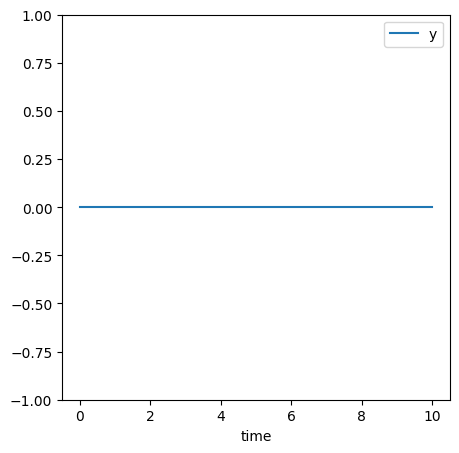

In [9]:
def designClosedLoop(open_loop_tf, is_kP=True, is_kI=True, is_kD=True, is_kDD=False,
                     is_kF=True, amp=1, times=TIMES, kmax=1e4, is_warnings=True):
    """
    Finds parameters for the closed loop system that eliminate noise and have a good step response.
    By default the closed loop system has a PID controller and a filter. By changing is_<k>,
    you can select variations in the design.
    
    Paramters
    ---------
    open_loop_tf: control.TransferFunction (OLS transfer function)
    is_<k>: bool (include the design element)
    amp: 0 <=float  (amplitude of the sine wave used to evaluate noise response)
    times: array-float
    kmax: float (maximum value of a constant)
    
    Returns
    -------
    DesignResult
    """
    NOISE_FREQ = 20*2*np.pi
    step_inputs = np.repeat(1, len(times))
    ideal_step_outputs = step_inputs
    noise_inputs = amp*np.sin(NOISE_FREQ*times) # Sinusoid input
    ideal_noise_outputs = np.repeat(0, len(times))
    def calculateDesignResiduals(params):
        """
        Calculates the residuals with an ideal step response.

        Parameters
        ----------
        params: lmfit.Parameters

        Returns
        -------
        array-float
        """
        cltf = makeCLTransferFunctions(open_loop_tf, params, is_warnings=is_warnings)
        gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
        # Calculate residuals for a step response
        _, step_est = control.forced_response(gRM_tf, T=times, U=1)
        step_residuals = ideal_step_outputs - step_est
        # Calculate residuals for a sinusoidal noise input
        _, sinusoid_est = control.forced_response(gNM_tf, T=times, U=noise_inputs)
        sinusoid_residuals = ideal_noise_outputs - sinusoid_est
        #
        return step_residuals + sinusoid_residuals
    # 
    params = lmfit.Parameters()
    if is_kP:
        params.add("kP", value=1, min=0, max=kmax)
    if is_kI:
        params.add("kI", value=1, min=0, max=kmax)
    if is_kD:
        params.add("kD", value=1, min=0, max=kmax)
    if is_kDD:
        params.add("kDD", value=1, min=0, max=kmax)
    if is_kF:
        params.add("kF", value=1, min=0, max=kmax)
    minimizer_result = lmfit.minimize(calculateDesignResiduals, params)
    new_params = minimizer_result.params
    #
    cltf = makeCLTransferFunctions(gO_tf, new_params, is_warnings=is_warnings)
    gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
    design_result = DesignResult(grm=gRM_tf, gnm=gNM_tf, params=new_params, det=minimizer_result)
    return design_result

# Tests
is_plot = True
gO_tf = control.TransferFunction([1], [1, 1, 1])
design_result = designClosedLoop(gO_tf, kmax=1e10, amp=10, is_kD=True, is_kDD=False, is_warnings=False)
times = np.linspace(0, 10, 100)
noise_inputs = np.sin(20*2*np.pi*times) # Sinusoid i
plotSys(design_result.gnm, times=times, ylim=[-1, 1],
                                          forced_input=noise_inputs, is_plot=is_plot)
assert(isinstance(design_result.grm, control.TransferFunction))
print("OK!")

In [10]:
design_result.params

name,value,standard error,relative error,initial value,min,max,vary
kP,3885582.38,1.4747e+10,(379534.18%),1,0.00000000,1.0000e+10,True
kI,48.5936580,6.7743e+09,(13940757744.75%),1,0.00000000,1.0000e+10,True
kD,20452.3670,1.2348e+10,(60372287.14%),1,0.00000000,1.0000e+10,True
kF,289049.001,8.7851e+12,(3039326889.35%),1,0.00000000,1.0000e+10,True


## ``plotDesignResult``

In [11]:
# Plots of the transfer functions
def plotDesignResult(design_result, ax=None, end_time=50, title="", is_plot=True, **kwargs):
    """
    Plots a DesignResult.
    
    Parameters
    ----------
    design_result: DesignResult
    ax: Matplotlib.Axes
    end_time: float
    is_plot: bool
    kwargs: dict (other plotting options)
    """
    if ax is None:
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (3, 3)
        _, ax = plt.subplots(1, figsize=figsize)
    times = np.linspace(0, end_time, 2000)
    plot_result1 = plotSys(design_result.grm, forced_input=1, times=times, ax=ax,
                         is_legend=False)
    plot_result2 = plotSys(design_result.gnm, forced_input=np.sin(5*times), times=times, 
            is_legend=False, ax=ax)
    if "ylim" in kwargs.keys():
        ylim = kwargs["ylim"]
    else:
        ylim = ax.set_ylim()
    xpos = end_time*1.1
    yspan = ylim[1] - ylim[0]
    ypos1 = ylim[1] - 0.1*yspan
    ypos2 = ypos1 - 0.2*yspan
    ax.text(xpos, ypos1, "G_RM", c="blue")
    ax.text(xpos, ypos2, "G_NM", c="orange")
    ax.set_ylim(ylim)
    ax.set_title(title)
    if not is_plot:
        plt.close()
 
# Tests
plotDesignResult(design_result, kmax=1, figsize= (2,2), is_plot=False, end_time=5)
print("OK!")

OK!


## ``plotStaircaseResponse``

In [12]:
# def plotStaircaseResponse(builder, is_plot=True, **kwargs):
#     """
#     This function circumvents a bug in SISOTransferFunctionBuilder.plotStairCaseResponse.
#     It has the same arguments and return value as the original function.
#     """
#     plot_result = builder.plotStaircaseResponse(is_plot=False, **kwargs)
#     # Plot if requested
#     if is_plot:
#         times = np.array(plot_result.time_series.index)/1000
#         df = pd.DataFrame(plot_result.time_series)
#         df.index = times
#         if "figsize" in kwargs.keys():
#             figsize = kwargs["figsize"]
#         else:
#             figsize = (10, 10)
#         legends = list(df.columns)
#         fig, ax = plt.subplots(1, figsize=figsize)
#         staircase_column = [c for c in df.columns if "staircase" in c][0]
#         staircase_values = df[staircase_column].values
#         del df[staircase_column]
#         ax.plot(df)
#         ax2 = ax.twinx()
#         # Plot the staircase
#         ax2.plot(times, staircase_values, color="red",
#               linestyle="--")
#         ax2.set_ylabel(staircase_column, color="red")
#         ax.legend(df.columns)
#     #
#     return plot_result

# # TESTS
# plot_response = plotStaircaseResponse(LINEAR_BLDR, initial_value=2, final_value=10, num_step=5, figsize=(3,3),
#                                     legend_crd=(0.5, 1), end_time=100, is_plot=False)
# assert(isinstance(plot_response.time_series, ctl.Timeseries))
# print("OK!")

## ``makePIController``

In [13]:
def makePIController(kP=20, kI=10):
    """
    Makes a PI controller with control error as input
    
    Parameters
    ----------
    kP: float
    kI: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        return u[0]

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        output = kI*x[0] + kP*u[0]
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
kP = 10
kI = 20
controller_sys = makePIController(kP=kP, kI=kI)
assert("NonlinearIOSystem" in str(type(controller_sys)))
plot_result = plotSys(controller_sys, forced_input=[1], is_plot=False)
data = plot_result.y_arr
assert(data[0] == kP)
assert(np.isclose(data[-1], kP + plot_result.times[-1]*kI))
print("OK")

OK


## ``makePIDController``

In [14]:
def makePIDController(kP=20, kI=10, kD=0, kDD=0):
    """
    Makes a PI controller with control error as input
    
    Parameters
    ----------
    kP: float
    kI: float
    kD: float
    kDD: float (coefficient for second derivative of input)
    
    Returns
    -------
    NonlinearIOSystem
    """
    derivative1 = makeDerivative()
    derivative2 = makeDerivative()
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (sum of input, last input)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        return u[0]

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        du = derivative1(t, u[0])
        ddu = derivative2(t, du)
        output = kP*u[0] + kI*x[0] + kD*du + kDD*ddu
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
is_plot = False
kP = 10
kI = 20
kD = 100
controller_sys = makePIDController(kP=kP, kI=kI, kD=0)
assert("NonlinearIOSystem" in str(type(controller_sys)))
plot_result = plotSys(controller_sys, forced_input=[1], is_plot=is_plot)
data = plot_result.y_arr
assert(data[0] == kP)
assert(np.isclose(data[-1], kP + plot_result.times[-1]*kI))
#
controller_sys = makePIDController(kP=kP, kI=kI, kD=kD, kDD=10)
inputs = np.sin(TIMES)
plot_result = plotSys(controller_sys, forced_input=inputs, is_plot=is_plot)

print("OK")

OK


## ``makeFilter``

In [15]:
def makeFilter(system_name="filter_sys", kF=1):
    """
    Makes a filter.
    
    Parameters
    ----------
    system_name: str
    kF: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state, averaged signal)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        dy = kF*u[0] - kF*x[0]
        return dy

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return x[0]

    filter_sys = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name=system_name)
    return filter_sys

# Tests
kF = 1
filter_sys = makeFilter(kF=kF)
assert("NonlinearIOSystem" in str(type(filter_sys)))
plot_result = plotSys(filter_sys, forced_input=[1], times=np.linspace(0, 100, 1000), is_plot=False)
data = plot_result.y_arr
assert(np.abs(data[-1] - 1) < 0.01)
print("OK")

OK


## ``makeSinusoid``

In [16]:
def makeSinusoid(system_name="sinusoid_sys", amplitude=1, frequency=20):
    """
    Makes a sinusoidal signal, the only output.
    
    Parameters
    ----------
    system_name: str
    amplitude: float (amplitude of the sinusoid)
    frequency: float (frequencay of the sinusoid)
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return amplitude*np.sin(t*2*np.pi*frequency)

    sinusoid_sys = control.NonlinearIOSystem(
      None,
      outfcn,
      inputs=0,
      outputs=['out'],
      name=system_name)
    return sinusoid_sys

# Tests
sinusoid_sys = makeSinusoid(amplitude=10)
assert("NonlinearIOSystem" in str(type(sinusoid_sys)))
plot_result = plotSys(sinusoid_sys, forced_input=1, times=np.linspace(0, 10, 1000), is_plot=False)
count = len([v for v in plot_result.y_arr[0] if v >= 0.999])
assert(count > 1)
print("OK")

OK


## ``makeAdder``

In [17]:
def makeAdder(input_names, output_name="out", system_name="adder_sys"):
    """
    Creates a NonlinearIOSystem that does addition
    of the inputs. Any name that begins wit a "-" is subtracted.
    
    Parameters
    ----------
    input_nmames: list-str
    output_name: str
    system_name: str
    
    Returns
    -------
    NonlinearIOSystem
    """
    adjustments = []
    adjusted_input_names = []
    def outfcn(_, __, u, ___):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return adjustments.dot(u)
    #
    for name in input_names:
        if name[0] == "-":
            value = -1
            new_name = name[1:]
        else:
            value = 1
            new_name = name
        adjustments.append(value)
        adjusted_input_names.append(new_name)
    adjustments = np.array(adjustments)
    #
    return control.NonlinearIOSystem(
          None,
          outfcn,
          inputs=adjusted_input_names,
          outputs=output_name, name=system_name)

# Tests
adder_sys = makeAdder(["a", "-b", "c"])
assert("NonlinearIOSystem" in str(type(adder_sys)))
# Simulate to verify 
plot_result = plotSys(adder_sys, forced_input=[3, 2, 4], is_plot=False)
data = plot_result.y_arr
assert(np.var(data[0]) == 0)
assert(data[0][0] == 5)
print("OK")

OK


## ``makeClosedLoopSystem``

In [18]:
def makeClosedLoopSystem(ctlsb, kP=1, kI=1, kF=1, kD=0, kDD=0, noise_amplitude=1,
                         noise_frequency=20):
    """
    Create a closed loop system with a controller and filter for an SBML model.
    
    Parameters
    ----------
    ctlsb: ControlSBML (for open loop system)
    kP: float
    kI: float
    kD: float
    kF: float
    noise_amplitude: float
    noise_frequency: float
    
    Returns
    -------
    Interconnect
    """
    # Information for open loop system
    if len(ctlsb.input_names) != 1:
        raise ValueError("Open loop system should have exactly 1 input")
    if len(ctlsb.output_names) != 1:
        raise ValueError("Open loop system should have exactly 1 output")
    open_sys = ctlsb.makeNonlinearIOSystem("open_sys")
    sinusoid_sys = makeSinusoid(system_name="sinusoid_sys",
                                amplitude=noise_amplitude, frequency=noise_frequency)
    open_input = "open_sys.%s" % ctlsb.input_names[0]
    open_output = "open_sys.%s" % ctlsb.output_names[0]
    # Other elements
    filter_sys = makeFilter(kF=kF)
    controller_sys = makePIDController(kP=kP, kI=kI, kD=kD, kDD=kDD)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    adder_sys = makeAdder(["noise", "open_sys"], system_name="adder_sys")
    closed_sys = control.interconnect(
      [adder_sys, sinusoid_sys, open_sys, controller_sys, differ_sys, filter_sys],       # systems
      connections=[
        ['adder_sys.noise', "sinusoid_sys.out"],
        ['adder_sys.open_sys', open_output],
        ['filter_sys.in', "adder_sys.out"],
        ['differ_sys.measurement', 'filter_sys.out'],
        ['controller_sys.in',  'differ_sys.out'],
        [open_input, 'controller_sys.out'],
      ],
      inplist=["differ_sys.setpoint"],
      outlist=["adder_sys.out", "controller_sys.out"],
    )
    return closed_sys

# Tests
setpoint = 1
new_closed_sys = makeClosedLoopSystem(TEST_CTLSB, noise_amplitude=1, kP=1, kI=0.1, kD=0.2, kDD=0.1, kF=1000)
assert("Interconnect" in str(type(new_closed_sys)))
plot_result = plotSys(new_closed_sys, forced_input=[setpoint], times=np.linspace(0, 30, 100), 
                      is_plot=False, output_labels=["s5", "control_input"])
data = plot_result.y_arr
assert(data[0][0] == 0)
assert(np.abs(setpoint - data[0][-1]) < 0.2)
print("OK!")

OK!


# Step 1. Problem Statement (15 pts)

## Problem Statement
Describe the control problem that you are addressing.

This project involves examining an ordinary differential equation model of acute inflammatory response to infection. In organisms of nearly every level of complexity, the body responds to trauma with an inflammatory response to promote adaptation to stress, elimination of a pathogen/foreign body, and healing of affected tissues/organs. This response, while necessary as a defense mechanism, can be extremely damaging to the organism in excess. Thus, organisms have complex systems for regulating the severity of an acute inflammatory response via controlling molecular cascades.

These controls can be broadly grouped into 1) pro-inflammatory elements that attack and remove the pathogen and 2) anti-inflammatory elements that downregulate the pro-inflamatory elements via negative feedback loops.

## System studied
Specify the input and output to your system, simulate its open loop behavior, and plot the results.

In Reynolds et. al, a simplified model is proposed that relates a pro and anti-inflammation response to some initiating event, P. Aside from these three parameters, a fourth parameter of tissue damage (D) is introduced as an inducer of both the pro and anti-inflammation responses.

The goal of this system is to understand the role of the time-dependent anti-inflammatory response.

The specific subsystem I am choosing to examine if the Nstar/D subsystem:

**Input**: Activated phagocytes (pro-inflammation response)

**Output**: Tissue damage

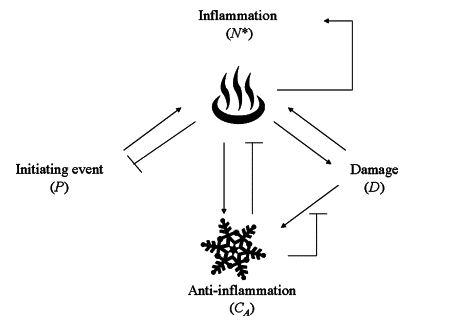

**Some thoughts:**

I want to control the Nstar input to influence the Damage output. Damage comes from increased Nstar and is reduced by C_A. Nstar also prompts C_A deposition, while C_A inhibits Nstar and damage. Nothing really inihibits the anti-inflammatory response in this model, so we would want it to react without limit to the stimuli of damage/pro-inflammatory response. I think a derivative controller may be useful for controlling C_A, while an integral controller would be useful for controlling Nstar.

I found during exploration in previous assignments that P(Pathogen) output can be directly controlled by Nstar. The relationship is fairly simple, with the associated transfer function having a numerator degree of 0 and denominator degree of 1, with fairly large, negative poles. In this assignment, I want to a tackle a more complicated problem, which is controlling tissue damage with an Nstar (inflammation response) input.

I've also found that while controlling C_A would be interesting, in this model it is very difficult to control Damage with C_A as the input (runtime warnings in most sensible architectures), so I am focusing on Nstar.

Issues:
1) When making CL testbed for Damage output: RuntimeError: solve_ivp failed: Required step size is less than spacing between numbers. Damage seems to be a very difficult parameter to control.

2) Cannot use a transfer function with numerator deg > 1 and denominator deg > 2 without getting a RuntimeError.

In [19]:
"""
Model for control of acute inflammatory response



Links: Paper -> https://pubmed.ncbi.nlm.nih.gov/16584750/
       Model -> https://www.ebi.ac.uk/biomodels/BIOMD0000000714#Files

Paramaters:

1) P - Level of Pathogen
2) N - Activated phagocytes
3) C_A - Anti-inflammatory mediators
4) D - Tissue damage

For this system,

Input:
Activated Phagocytes

Output:
Tissue Damage

Want to examine the change in tissue damage as a result activated phagocyte response. When phagocytes respond to a pathogen
(another parameter), they can cause tissue damage as a byproduct.

"""

inflam_url = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000714.6?filename=HealthyOutcome.xml"



## Control objectives
State the control objectives

In this subsystem, activated phagocytes are responding to some pathogen/initiating event (P). However, this response collaterally causes tissue damage, inciting an anti-inflammatory response (C_A). This secondary response inhibits tissue damage as well as pro-inflammation response, while the tissue damage both activated more phagocytes and intitiates an anti-inflammatory response.

Therefore, am I interested in understanding how different levels of pro-inflammation response will affect tissue damage, and how aggressive anti-inflammation response will become as tissue damage increases.

Control input: **Activated Phagocytes**

Control output: **Tissue Damage**

Setpoint: I want to examine what kind of activated phagocyte levels will cause the tissue damage to go to zero. Furthermore, as tissue damage increases due to the phagocytes, I'd like to understand how the anti-inflammatory response will drive the tissue damage back down.

Right now, tissue damage peaks around 30 seconds and does not go back to zero until about 200 seconds. The goal here is to reduce that spike as well as the response time, such that damage approaches zero more quickly.

**Control Objectives:**

1) Control Damage towards 0
2) Minimize response time of damage to changes in inflammatory response
3) Reduce/eliminate oscillations

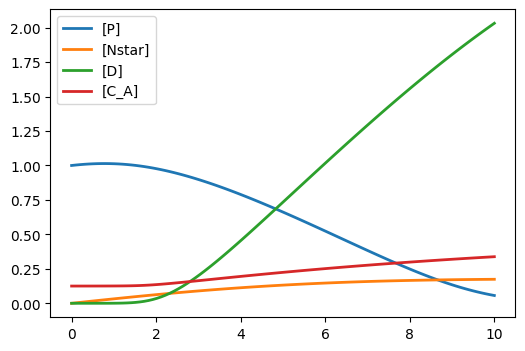

In [20]:
INFLAM_CTLSB = ctl.ControlSBML(inflam_url, input_names=['Nstar'], output_names=['D'])

INFLAM_CTLSB_RR = INFLAM_CTLSB.roadrunner
INFLAM_CTLSB_RR.simulate(0, 10, 100)
INFLAM_CTLSB_RR.plot()

In [21]:
# print(INFLAM_CTLSB.antimony)

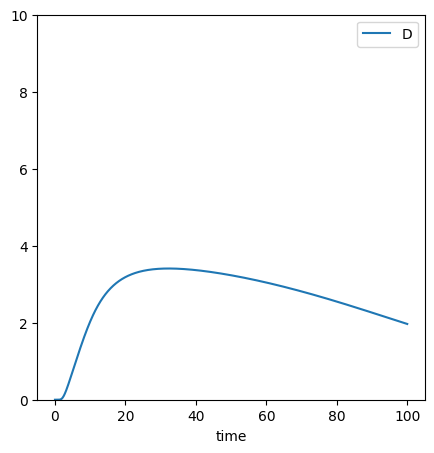

In [22]:
#plot model with just output component of interest, the phagocyte-damage system

n_d_sys = INFLAM_CTLSB.makeNonlinearIOSystem("n_d_sys")
ts = ctl.simulateSystem(n_d_sys, end_time=100)
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[0, 10])

## Controllability and operating region
1. Do a staircase plot of the control input's effect on the measured output from your system.
1. Determine the operating region, the range of (control) inputs to your system that you will use.

To get any step response of tissue damage to Nstar input, we have to use an extremely small operating region.

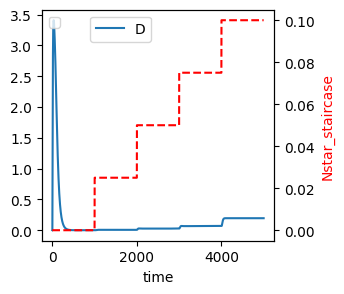

In [47]:
inflam_builder = INFLAM_CTLSB.makeSISOTransferFunctionBuilder()
inflam_builder.input_name, inflam_builder.output_name

inflam_builder.plotStaircaseResponse(initial_value=0, final_value=0.1, figsize=(3,3),
                                    legend_crd=(0.5, 1), end_time=5000)

# Step 2. System Identification (15 pts)

Here, we estimate a transfer function for the system over the operating range. This was optimized in HW2 for input of Nstar and output of P. Now, we must readjust for output of D.

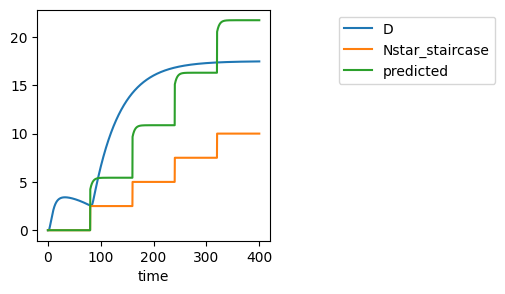

In [24]:
num_degree = 1
denom_degree = 2

fitter_result =  inflam_builder.fitTransferFunction(num_degree+1, denom_degree+1, final_value=10,initial_value=0, end_time=400)

ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

Any transfer function I try with a denominator > 2 becomes very problematic to run. The block of code takes > 30 minutes to run.

## Estimated transfer function

1. Estimate the transfer function over the operating range and evaluate the quality of the estimate by plotting the 
true system output and the output predicted by the transfer function.
1. Show the transfer function.

In [25]:
#transfer functionWhat is the DC gain? What are the poles? What are the implications for control?

INFLAM_TF = fitter_result.transfer_function

print(INFLAM_TF)


        1.381 s + 0.4017
---------------------------------
2.608e-05 s^2 + 0.8282 s + 0.1848



## Evaluation of the quality of the estimated transfer function

Analyze the expected impact of the accuracy of the transfer function on the closed loop design.

In [26]:
#std error

fitter_result.stderr

{'n0': 37626.993762765065,
 'n1': 10944.06919354047,
 'd0': 0.709219993643607,
 'd1': 22562.14429189864,
 'd2': 5035.418639603422}

In [27]:
#number of simulations to find best transfer function

fitter_result.nfev

107

In [28]:
#DC gain

fitter_result.transfer_function.dcgain()

2.173534798865417

In [29]:
#poles

fitter_result.transfer_function.poles()

array([-3.17627457e+04+0.j, -2.23129415e-01+0.j])

The dominant pole here is extremely close to zero, suggesting a pretty slow response time. If damage is being caused to organs and tissue, this is really bad! My object is to see if I can improve upon this slow response.

# Step 3. Optimization-Based Control Design (40 pts)

1. Designs a closed loop system that achieves our control objectives. By "design" is meant finding values
of $k_P, k_I, k_D, k_F$.
1. Consider noise in the design. Noise is specified by a high frequency sinewave, 20 Hz.

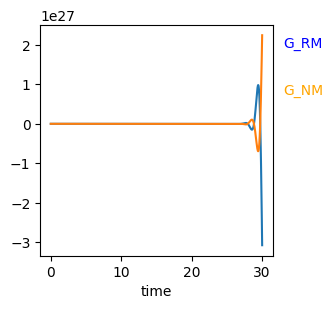

In [30]:
times = np.linspace(0, 30, 200)
INFLAM_DESIGN_RESULT  = designClosedLoop(INFLAM_TF, kmax=100,
                                       is_kD=True,
                                 amp=200, times=times, is_warnings=False)
plotDesignResult(INFLAM_DESIGN_RESULT, end_time=max(times))

#oscillations are out of control!

In [31]:
INFLAM_DESIGN_RESULT.params

name,value,standard error,relative error,initial value,min,max,vary
kP,3.0815e-08,0.43742257,(1419513082.90%),1,0.00000000,100.000000,True
kI,99.9999734,13.7020411,(13.70%),1,0.00000000,100.000000,True
kD,1.8875e-05,9.2121e-06,(48.80%),1,0.00000000,100.000000,True
kF,9.96279020,2.36004536,(23.69%),1,0.00000000,100.000000,True


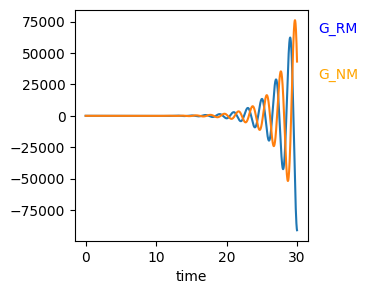

In [32]:
#oscillations still occuring on far too large of a scale

times = np.linspace(0, 30, 200)
INFLAM_DESIGN_RESULT  = designClosedLoop(INFLAM_TF, kmax=10,
                                       is_kD=True, is_kI=True,
                                 amp=200, times=times, is_warnings=False)
plotDesignResult(INFLAM_DESIGN_RESULT, end_time=max(times))

In [33]:
INFLAM_DESIGN_RESULT.params

name,value,standard error,relative error,initial value,min,max,vary
kP,9.99999541,3.19852412,(31.99%),1,0.00000000,10.0000000,True
kI,9.99999941,0.69969374,(7.00%),1,0.00000000,10.0000000,True
kD,1.8948e-05,7.9173e-05,(417.85%),1,0.00000000,10.0000000,True
kF,9.99740879,28.4677526,(284.75%),1,0.00000000,10.0000000,True


This architecture has the DC gain settling at 1. Setting is_kF = False makes this process faster.

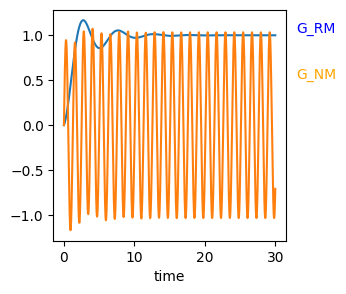

In [34]:
times = np.linspace(0, 30, 200)
INFLAM_DESIGN_RESULT  = designClosedLoop(INFLAM_TF, kmax=1,
                                       is_kD=True, is_kI=True, is_kF=False,
                                 amp=10, times=times, is_warnings=False)
plotDesignResult(INFLAM_DESIGN_RESULT, end_time=max(times))

In [35]:
INFLAM_DESIGN_RESULT.params

name,value,standard error,relative error,initial value,min,max,vary
kP,1.00000000,0.00900538,(0.90%),1,0.00000000,1.00000000,True
kI,0.99945680,0.25883351,(25.90%),1,0.00000000,1.00000000,True
kD,0.19915734,0.71624113,(359.64%),1,0.00000000,1.00000000,True


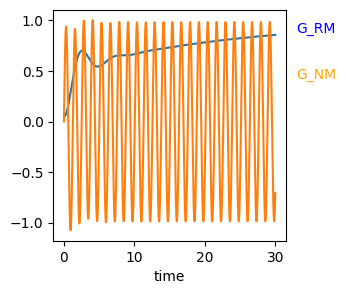

In [36]:
times = np.linspace(0, 30, 200)
INFLAM_DESIGN_RESULT  = designClosedLoop(INFLAM_TF, kmax=1,
                                       is_kDD=True, is_kD=False, is_kI=True, is_kF=False,
                                 amp=10, times=times, is_warnings=False)
plotDesignResult(INFLAM_DESIGN_RESULT, end_time=max(times))

In [37]:
INFLAM_DESIGN_RESULT.params

name,value,standard error,relative error,initial value,min,max,vary
kP,1.00000000,0.97354260,(97.35%),1,0.00000000,1.00000000,True
kI,0.08136585,0.04455516,(54.76%),1,0.00000000,1.00000000,True
kDD,0.05565766,0.00394036,(7.08%),1,0.00000000,1.00000000,True


Lowering the value of kmax by an order of magnitutde in each of these trials has greatly tampered noise and helped achieve a DC gain of 1. Thus, we can move forward with kmax=1.

Adding a DD control element has also reduced the oscillation.

# Step 4. Testbed evaluations (15 pts)

This step builds a testbed for the system designed in the previous step, and does simulation runs to assess performance relative to the control objectives.

## Implementation

Use the helper ``makeClosedLoopSystem``to do control design. Some iteration may be required.

In [38]:
SETPOINT = 0
INFLAM_TIMES = np.linspace(0, 40, 400)

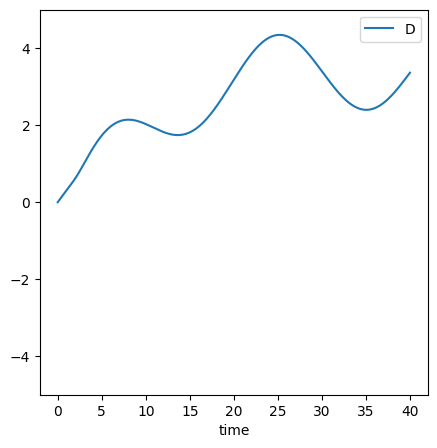

In [39]:
# Open loop system with controllers set to zero

inflam_closed_sys = makeClosedLoopSystem(INFLAM_CTLSB, kP=0, kI=0, kF=0, kD=0, noise_amplitude=1, noise_frequency=20)
plot_result = plotSys(inflam_closed_sys, forced_input=[SETPOINT], times=INFLAM_TIMES, 
                      is_plot=True, output_labels=["D"], ylim=[-5,5])

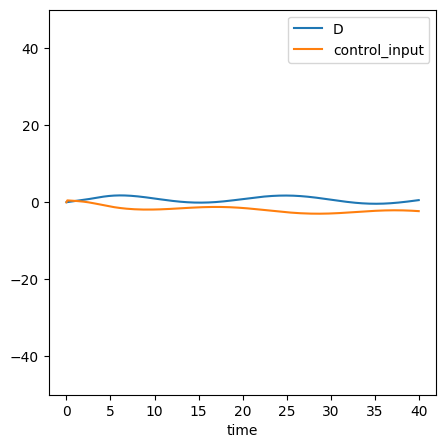

In [40]:
# System with design parameters
#set y_lim to +/- 50 to get good picture of control input fluctuation

kP = INFLAM_DESIGN_RESULT.params["kP"].value
kI = INFLAM_DESIGN_RESULT.params["kI"].value

if "kF" in INFLAM_DESIGN_RESULT.params.keys():
    kF = INFLAM_DESIGN_RESULT.params["kF"].value
else:
    kF = 100
if "kD" in INFLAM_DESIGN_RESULT.params.keys():
    kD = INFLAM_DESIGN_RESULT.params["kD"].value
else:
    kD = 1
    
inflam_closed_sys = makeClosedLoopSystem(INFLAM_CTLSB, kP=kP, kI=kI, kD=kD, kF=kF,
                                      noise_amplitude=1, noise_frequency=20)
plot_result = plotSys(inflam_closed_sys, forced_input=[SETPOINT], times=INFLAM_TIMES, 
                      is_plot=True, output_labels=["D", "control_input"], ylim=[-50,50])

## Tuning

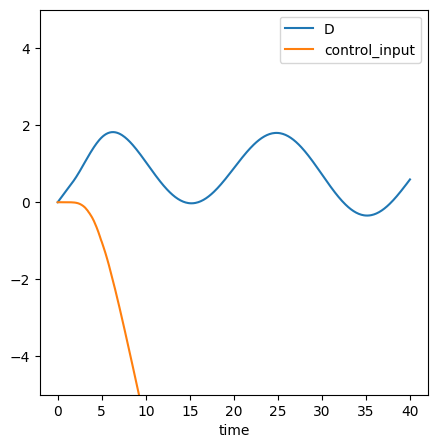

In [41]:
# System with design parameters
#set y_lim to +/- 5 to get good picture of response fluctuation
#include kDD control

kP = INFLAM_DESIGN_RESULT.params["kP"].value
kI = INFLAM_DESIGN_RESULT.params["kI"].value
kDD = INFLAM_DESIGN_RESULT.params["kDD"].value
if "kD" in INFLAM_DESIGN_RESULT.params.keys():
    kD = INFLAM_DESIGN_RESULT.params["kD"].value
else:
    kD = 1
inflam_closed_sys = makeClosedLoopSystem(INFLAM_CTLSB, kP=1, kI=1, kDD=kDD, kD=0, kF=1,
                                      noise_amplitude=1, noise_frequency=20)
plot_result = plotSys(inflam_closed_sys, forced_input=[SETPOINT], times=INFLAM_TIMES, 
                      is_plot=True, output_labels=["D", "control_input"], ylim=[-5,5])

To achieve the above response, Nstar must be removed from system at an unreasonable rate.

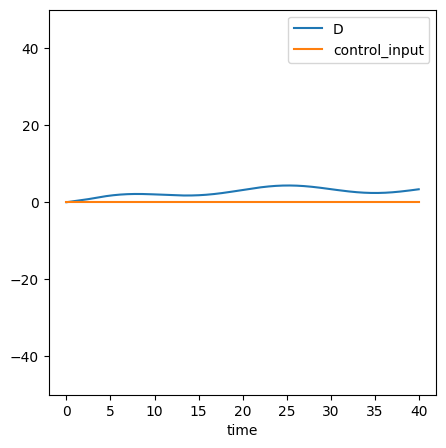

In [42]:
# System with design parameters
#set y_lim to +/- 5 to get good picture of response fluctuation
#increase integral control to 2 (would like to go higher but runtime error prevents this)

kP = INFLAM_DESIGN_RESULT.params["kP"].value
kI = INFLAM_DESIGN_RESULT.params["kI"].value
if "kF" in INFLAM_DESIGN_RESULT.params.keys():
    kF = INFLAM_DESIGN_RESULT.params["kF"].value
else:
    kF = 10
inflam_closed_sys = makeClosedLoopSystem(INFLAM_CTLSB, kP=1, kI=2, kD=0, kF=0,
                                      noise_amplitude=1, noise_frequency=20)
plot_result = plotSys(inflam_closed_sys, forced_input=[SETPOINT], times=INFLAM_TIMES, 
                      is_plot=True, output_labels=["D", "control_input"], ylim=[-50,50])

Decent response, but Damage is still oscillating above zero.

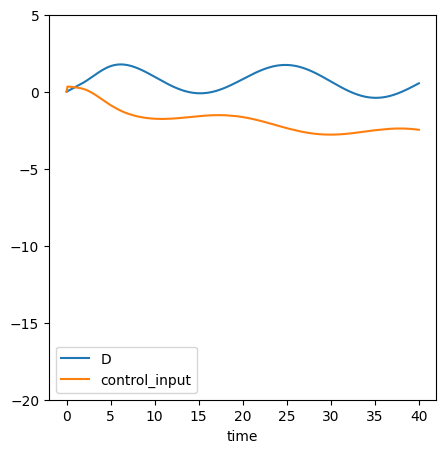

In [43]:
# System with design parameters
#set y_lim to +5/-20 to get good picture of response fluctuation as well as input magnitude necessary for response

kP = INFLAM_DESIGN_RESULT.params["kP"].value
kI = INFLAM_DESIGN_RESULT.params["kI"].value
kDD = INFLAM_DESIGN_RESULT.params["kDD"].value
if "kF" in INFLAM_DESIGN_RESULT.params.keys():
    kF = INFLAM_DESIGN_RESULT.params["kF"].value
else:
    kF = 10
inflam_closed_sys = makeClosedLoopSystem(INFLAM_CTLSB, kP=1, kI=kI, kDD=0, kF=50,
                                      noise_amplitude=1, noise_frequency=20)
plot_result = plotSys(inflam_closed_sys, forced_input=[SETPOINT], times=INFLAM_TIMES, 
                      is_plot=True, output_labels=["D", "control_input"], ylim=[-20,5])

The above design was the best I could get for achieving my control objectives. Here is why:

-Adding the filter was the only way D would oscillate around zero. We want to have D converge to zero, but I have not found an architecture than can achieve this.

-Although we are having to remove activated phagocytes (Nstar) in this architecture, the rate at which they must be removed is much lower with kF=50 as opposed to values of lower magnitude (see above trials).

-Increasing the magnitude of kP and kI causes a runtime error (cells take about 20 minutes to run, and then give the error). It is crucial that they are around 1 in terms of magnitude. Using a negative value of kI caused the value of D to increase instead of oscillating, thus creating a worse outcome in the context of this biological system. I set kI equal to the value given by my transfer function (0.445).

-This response mirrors what I saw while designing the closed loop system; we can tamper the output towards the setpoint, but removing noise has proved to be impossible.


# Step 5. Discussion (15 pts)

1. How does the operating range of the OLS in the stepbed compare with the operating range you used in Step 2?
1. How well are control objectives achieved?
1. What value did you get from doing control design?

1) The operating range I used in the OLS was miniscule (0 to 0.1). This was the maximum operating range that yielded any staricase response from D with Nstar as the input. In step 2, after fitting the transfer function, the operating range became more robust (1-10). Transitioning to the laplace domain improved my operating range of control.


2) I am able to get D to oscillate around my target setpoint of 0 by implementing a complete controller, with kP, kD, kDD all having values of 1 and kF having a value of 100. Increasing these constants gives me a runtime error. I suspect a higher value of integral control would tamper the oscillations, but I have yet to be able to run this code without an error.


3) I think practicing control design was a valuable experience, and to me the most important part of it was learning how utilizing different methods of control can manipulate a system. The first layer of mapping different types of control (proportional, integral, differential) to a specific goal provided a great background, and then gaining experience tweaking these control strategies for a unique system helped me understand the subtle complexities within different systems. The course also included a signficant aspect of reinforcement learning; a lot of the value I will take from this quarter was obtained by trying different control strategies, failing, and then trying something else. Finally, solving problems in the context of biology provided great exposure to really stubborn systems and highlighted how control design does not have a trivial formula for these types of systems. Effectively controlling biological machinery requires unique and iterative problem solving.